In [13]:
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import directed_hausdorff
from torch.utils.data import Dataset, DataLoader
import os

In [20]:
model = YOLO("./best.pt")

class YOLOTestDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, img_size=640):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform = transform
        self.img_size = img_size  # Ensure dimensions are divisible by 32

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize image and mask
        image = cv2.resize(image, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size))

        # Convert mask to binary
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']

        # Normalize and format image for YOLO
        image = image.transpose(2, 0, 1) / 255.0  # HWC to CHW and normalize to [0, 1]
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask


WARNING  Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


image 1/1 c:\Project\TRA235\yusheng\Safety-System-Design\Yolo\..\data\split\test\images\A_Peu_03_aug_1.jpg: 640x640 2 windows, 754.9ms
Speed: 5.0ms preprocess, 754.9ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict2
1 label saved to runs\segment\predict2\labels


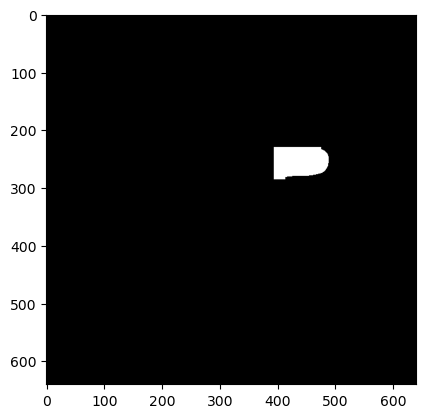

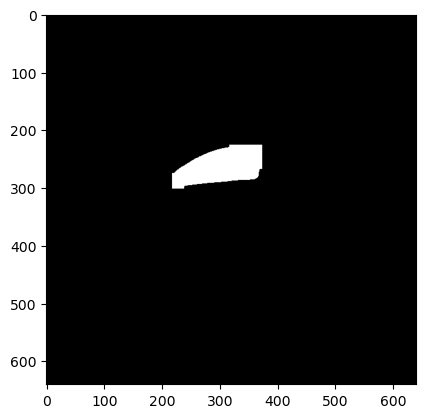

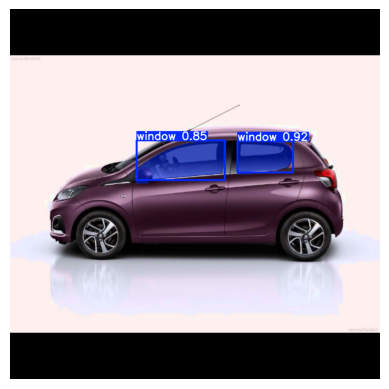

In [15]:
results = model.predict(
    source="../data/split/test/images/A_Peu_03_aug_1.jpg", #image
    show=True, 
    save=False, 
    conf=0.3, 
    line_width=1, 
    save_crop=True, 
    save_txt=True, 
    show_boxes=True, 
    show_labels=True, 
    show_conf=True, 
    classes=[0] 
)

masks = results[0].masks.data  



# Display every window:
for mask in masks:
    mask_np = mask.cpu().numpy()
    plt.imshow(mask_np, cmap="gray")  
    plt.show()

img_with_predictions = results[0].plot()
plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [22]:

def compute_metrics_yolo_dataset(model, dataloader):
    iou_scores = []
    dice_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    mae_scores = []
    hausdorff_distances = []

    for images, ground_truth_mask in dataloader:
        image = images[0].unsqueeze(0)  # Add batch dimension to match YOLO input format
        ground_truth_mask = ground_truth_mask[0]  # Unpack batch dimension

        # Predict using YOLO
        results = model.predict(source=image, save=False, conf=0.3, classes=[0], show=False)
        if results and results[0].masks is not None:
            predictions = results[0].masks.data  # YOLO segmentation masks
        else:
            predictions = []

        # Combine predicted masks
        prediction_mask = torch.zeros_like(ground_truth_mask, dtype=torch.float32)
        for mask in predictions:
            mask_np = mask.cpu().numpy()
            prediction_mask += torch.tensor(mask_np, dtype=torch.float32)

        prediction_mask = (prediction_mask > 0.5).float()

        # Compute metrics
        intersection = (prediction_mask * ground_truth_mask).sum().item()
        union = (prediction_mask + ground_truth_mask).sum().item() - intersection
        pred_sum = prediction_mask.sum().item()
        gt_sum = ground_truth_mask.sum().item()

        # IoU
        iou = intersection / (union + 1e-6)
        iou_scores.append(iou)

        # Dice
        dice = 2 * intersection / (pred_sum + gt_sum + 1e-6)
        dice_scores.append(dice)

        # Precision and Recall
        tp = intersection
        fp = pred_sum - intersection
        fn = gt_sum - intersection
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        precision_scores.append(precision)
        recall_scores.append(recall)

        # F1 Score
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        f1_scores.append(f1)

        # Mean Absolute Error (MAE)
        mae = torch.abs(prediction_mask - ground_truth_mask).mean().item()
        mae_scores.append(mae)

        # Hausdorff Distance
        pred_indices = torch.nonzero(prediction_mask, as_tuple=False).cpu().numpy()
        gt_indices = torch.nonzero(ground_truth_mask, as_tuple=False).cpu().numpy()
        if len(pred_indices) > 0 and len(gt_indices) > 0:
            hausdorff = max(
                directed_hausdorff(pred_indices, gt_indices)[0],
                directed_hausdorff(gt_indices, pred_indices)[0],
            )
        else:
            hausdorff = float("inf")  # Handle case with empty prediction or mask
        hausdorff_distances.append(hausdorff)

    # Aggregate metrics
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_mae = np.mean(mae_scores)
    mean_hausdorff = np.mean([d for d in hausdorff_distances if d != float("inf")])  # Exclude inf

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")
    print(f"Mean MAE: {mean_mae:.4f}")
    print(f"Mean Hausdorff Distance: {mean_hausdorff:.4f}")

    return {
        "iou": mean_iou,
        "dice": mean_dice,
        "precision": mean_precision,
        "recall": mean_recall,
        "f1": mean_f1,
        "mae": mean_mae,
        "hausdorff": mean_hausdorff,
    }


test_images_dir = "../data/split/test/images"
test_masks_dir = "../data/split/test/masks"

# Create the dataset and dataloader
test_dataset = YOLOTestDataset(test_images_dir, test_masks_dir, img_size=640)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Evaluate on the test set
metrics = compute_metrics_yolo_dataset(model, test_loader)



0: 640x640 (no detections), 783.1ms
Speed: 0.0ms preprocess, 783.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 windows, 730.0ms
Speed: 0.0ms preprocess, 730.0ms inference, 14.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 windows, 674.5ms
Speed: 0.0ms preprocess, 674.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 windows, 553.1ms
Speed: 0.0ms preprocess, 553.1ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 windows, 531.5ms
Speed: 0.0ms preprocess, 531.5ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 windows, 525.7ms
Speed: 0.0ms preprocess, 525.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 windows, 551.7ms
Speed: 0.0ms preprocess, 551.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 windows, 533.6ms
Speed: 0.0ms preprocess, 533.6ms inference, 6.5ms postproc